## This program deals with the corrective rag - The corrective rag follows the concept of fetching the information from web by recrating the query if documents are not relevant in rag vector DB

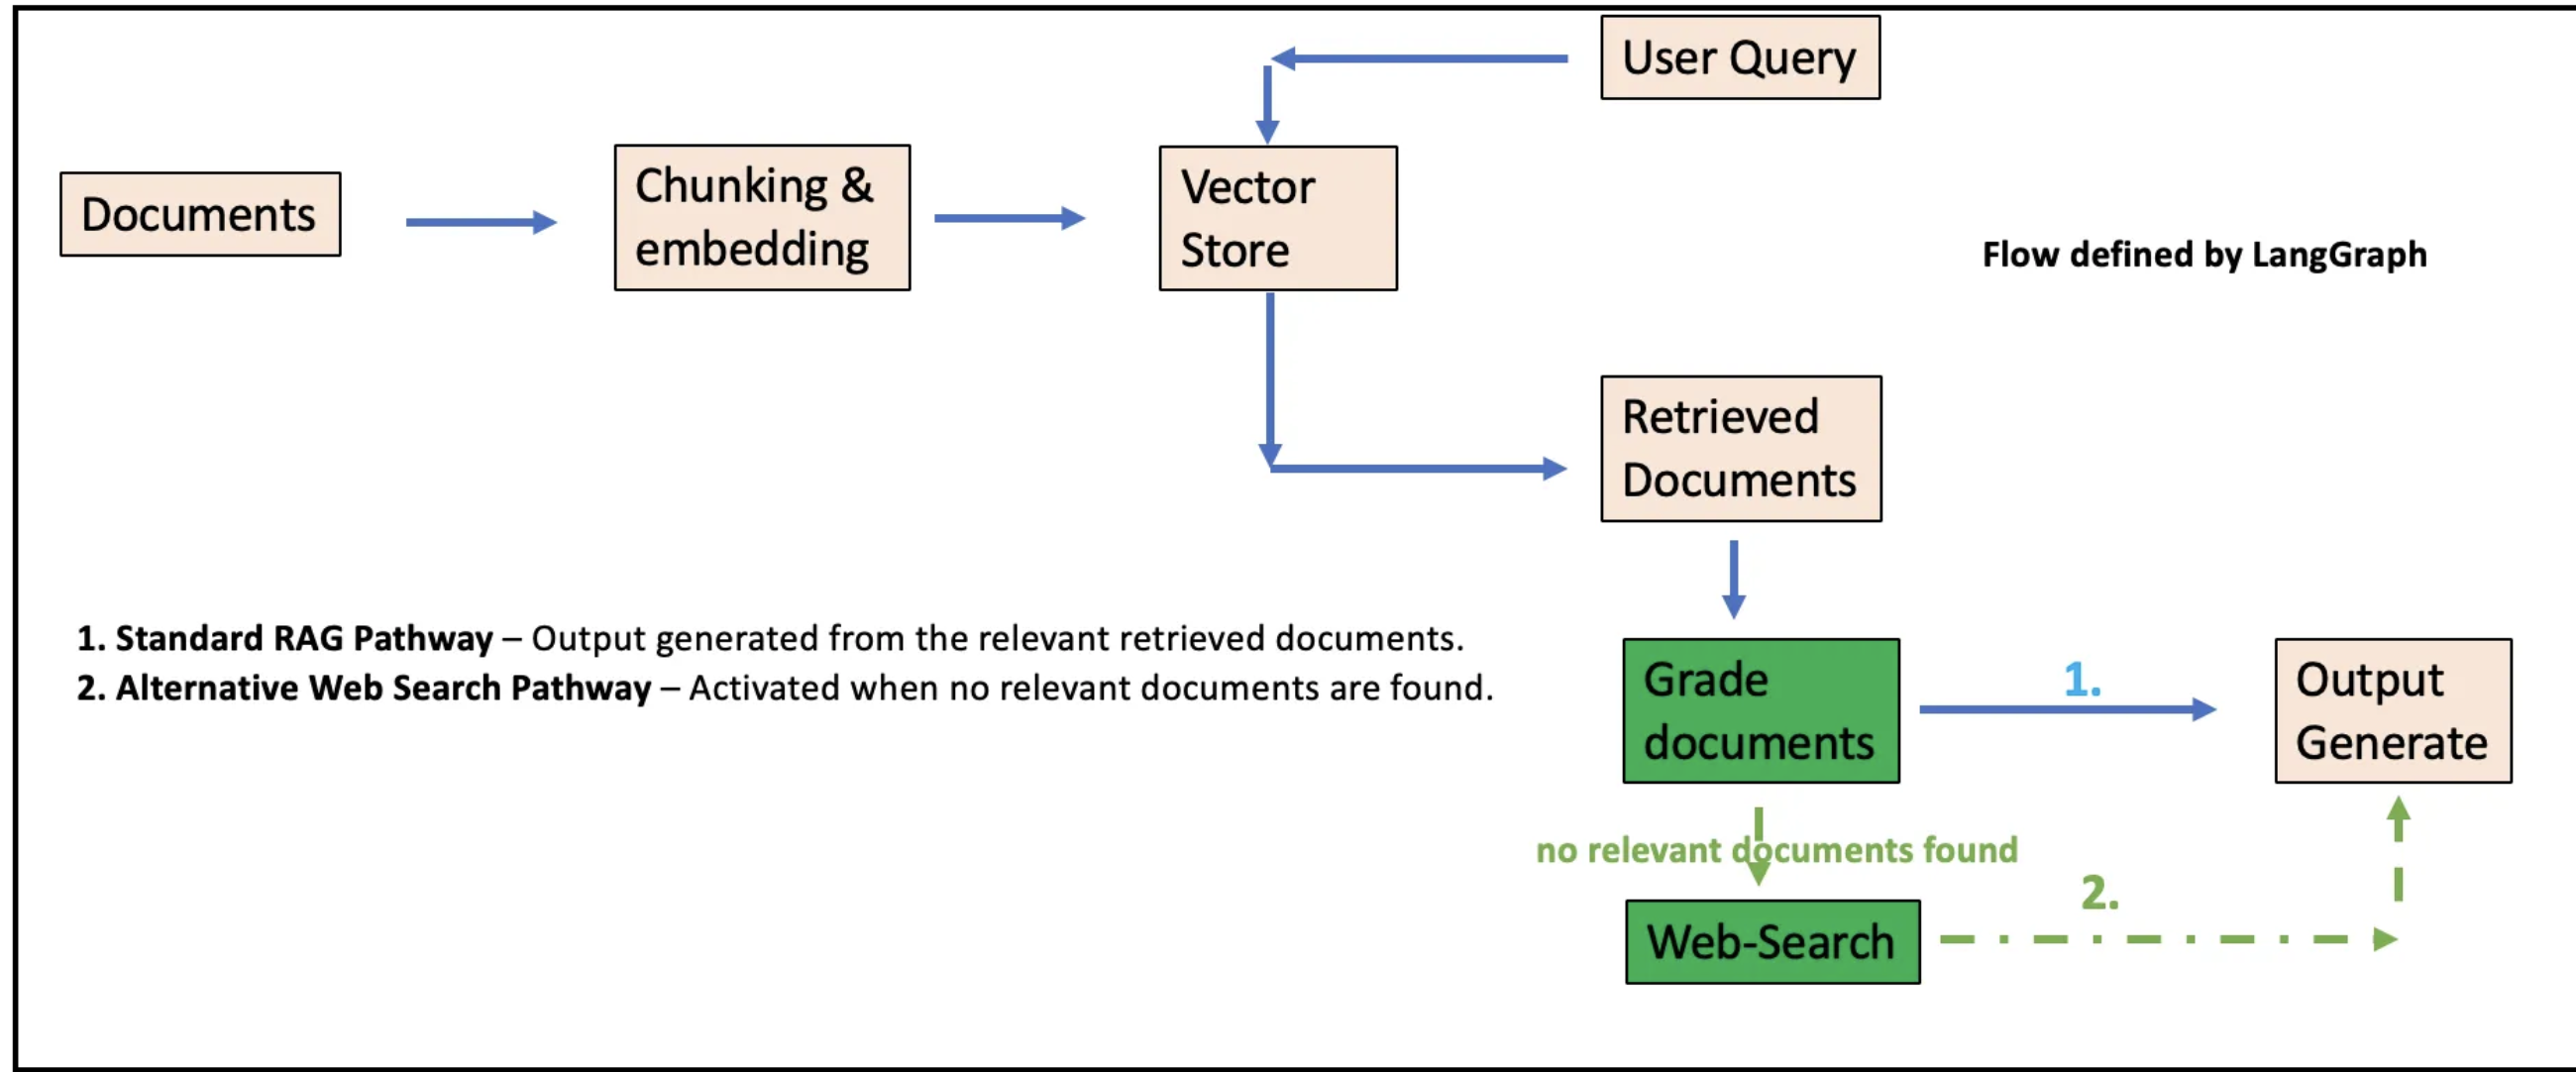

In [47]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display, Markdown
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from typing import TypedDict,Literal
from pydantic import BaseModel, Field
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
import bs4
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.agents import create_openai_tools_agent
from langchain.agents import AgentExecutor
import os


load_dotenv()

True

In [48]:
os.environ['LANGCHAIN_PROJECT']="Corrective RAG"

In [49]:
gpt_llm= ChatOpenAI(model="gpt-4o-mini")

In [50]:
class CorrectiveRag(TypedDict):
    grader:str
    question: str
    context: str
    result:str
    question_rewrite:str

In [51]:
class Grader(BaseModel):
    grader: Literal["Yes","No"] = Field(description="Document relevance as 'yes' or 'no'")

In [52]:
grader_structured=gpt_llm.with_structured_output(Grader)

In [53]:
urls = ["https://aws.amazon.com/what-is/langchain/",
        "https://www.ibm.com/think/topics/langchain"]

docs = [WebBaseLoader(url).load() for url in urls]

docs_list= [items for sublist in docs for items in sublist]
splitter=RecursiveCharacterTextSplitter(chunk_size= 500, chunk_overlap= 50)
docs_list
splitted_doc=splitter.split_documents(docs_list)
embeddings=OpenAIEmbeddings(model="text-embedding-3-small",dimensions=1024)
chromadatabase=Chroma.from_documents(splitted_doc,embeddings)
chromdb_retrieved_docs=chromadatabase.as_retriever(search_kwargs={"k": 3})

## Retrieval agents which fetches the right context

In [54]:
def retrieval_agent(state: CorrectiveRag) -> CorrectiveRag:
    context=chromdb_retrieved_docs.invoke(state["question"])
    return {"context":context} 

## Grader agents which will help in grading the document relevance to yes or no

In [55]:
def grader_agent(state: CorrectiveRag)-> CorrectiveRag:
    """
    Help in grading the documents based on the keywords and semantic meaning.

    Args: 
        question - user question
        context - documents context
    Returns:
        dictionary - update the grader
    """

    prompt = f"You are a grader llm. The classify the document relevancy to yes or no for the context:\n\n {state['context']} \n\n and user query : \n\n {state['question']}"
    result=grader_structured.invoke(prompt)
    return {"grader":result.grader}

## This generates the response for the user query and context either from the documents or wikipedia

In [56]:
def generate_agent(state: CorrectiveRag)-> CorrectiveRag:
    """
    Help in generating the answer based on the following context for the user query.

    Args: 
        question - user question
        context - documents context
    Returns:
        result - update the result
    """

    prompt = f"You are a rag llm. Based on the context :\n\n {state['context']} \n\n and user query : \n\n {state['question']}, help in generating the answer."
    result=gpt_llm.invoke(prompt)
    return {"result":result.content}

## This agent helps in tranforming the query to little detailed for better results

In [57]:
def transform_query_agent(state: CorrectiveRag)-> CorrectiveRag:
    """
    Help in transforming user query to a bit comprehensive one. Look for spelling,grammer mistakes.

    Args: 
        question - user question
        context - documents context
    Returns:
        result - update the result
    """

    prompt = f"You are a query re-writer llm. Based on the user query : \n\n {state['question']},generating a detailed query."
    result=gpt_llm.invoke(prompt)
    return {"question_rewrite":result.content}

## Grader condition

In [58]:
def grader_condition(state:CorrectiveRag) -> Literal["generate_agent","transform_query_agent"]:
    if state["grader"]=="Yes":
        return "generate_agent"
    else:
        return "transform_query_agent"

        

In [59]:
def internet_search_agent(state: CorrectiveRag) -> CorrectiveRag:
    api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=300)
    wikipedia = WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia)

    tools = [wikipedia]

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful research assistant who uses Wikipedia to answer questions."),
        ("human", "{question}"),
        MessagesPlaceholder("agent_scratchpad"), 
    ])

    agent_chain = create_openai_tools_agent(gpt_llm, tools, prompt)
    agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=False)

    result = agent_executor.invoke({"question": state["question_rewrite"]})
    return {"result": result["output"]}



In [60]:
graph =  StateGraph(CorrectiveRag)
graph.add_node("retrieval_agent",retrieval_agent)
graph.add_node("grader_agent",grader_agent)
graph.add_node("generate_agent",generate_agent)
graph.add_node("transform_query_agent",transform_query_agent)
graph.add_node("internet_search_agent",internet_search_agent)

graph.add_edge(START,"retrieval_agent")
graph.add_edge("retrieval_agent","grader_agent")
graph.add_conditional_edges("grader_agent",grader_condition)
graph.add_edge("generate_agent",END)
graph.add_edge("transform_query_agent","internet_search_agent")
graph.add_edge("internet_search_agent","generate_agent")


workflow=graph.compile()

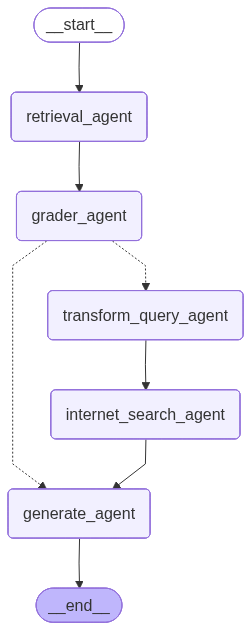

In [61]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [62]:
workflow.invoke({"question":"what is machine learning?"})

{'grader': 'No',
 'question': 'what is machine learning?',
 'context': [Document(metadata={'title': 'What is LangChain? - LangChain Explained - AWS', 'language': 'en-US', 'source': 'https://aws.amazon.com/what-is/langchain/', 'description': 'What is LangChain how and why businesses use LangChain, and how to use LangChain with AWS.'}, page_content='To do that, machine learning engineers must integrate the LLM with the organization’s internal data sources and apply prompt engineering—a practice where a data scientist refines inputs to a generative model with a specific structure and context.'),
  Document(metadata={'source': 'https://aws.amazon.com/what-is/langchain/', 'description': 'What is LangChain how and why businesses use LangChain, and how to use LangChain with AWS.', 'language': 'en-US', 'title': 'What is LangChain? - LangChain Explained - AWS'}, page_content='To do that, machine learning engineers must integrate the LLM with the organization’s internal data sources and apply pr